In [40]:
import shapely
import shapely.wkt
from shapely.geometry import Point, Polygon
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import descartes
import numpy as np
import json

## Clean the Grid Dataframe

In [41]:
pgh_grid = pd.read_csv('../Data/PGH/pgh_grid.csv')
pgh_grid = pgh_grid.rename(columns={'Unnamed: 0': 'cell_num'})
pgh_grid['tractce10'] = pgh_grid.tractce10.astype(str)

for row,col in pgh_grid.iterrows():
    pgh_grid.at[row, 'geometry'] = shapely.wkt.loads(pgh_grid.loc[row]['geometry'])
    pgh_grid.at[row, 'centroid'] = shapely.wkt.loads(pgh_grid.loc[row]['centroid'])
    
#     poly = geometry.Polygon([[p.x, p.y] for p in pointList])
    
    tract = pgh_grid.loc[row]['tractce10'].split('.')
    tract = tract[0]
    
    if len(tract) < 6 and tract != 'nan':
        tract = '0' + tract
    
    pgh_grid.at[row, 'tractce10'] = tract

In [42]:
type(pgh_grid.loc[0]['geometry'])

shapely.geometry.polygon.Polygon

In [43]:
pgh_grid

,cell_num,geometry,centroid,stations,capacity,ids,tractce10
0,0,"POLYGON ((-80.09992749314026 40.3616104190275,...",POINT (-80.09763209887167 40.36390581329607),0,0,set(),nan
1,1,POLYGON ((-80.09992749314026 40.36620120756465...,POINT (-80.09763209887167 40.36849660183323),0,0,set(),nan
2,2,"POLYGON ((-80.09992749314026 40.3707919961018,...",POINT (-80.09763209887167 40.37308739037038),0,0,set(),nan
3,3,POLYGON ((-80.09992749314026 40.37538278463895...,POINT (-80.09763209887167 40.37767817890753),0,0,set(),nan
4,4,"POLYGON ((-80.09992749314026 40.3799735731761,...",POINT (-80.09763209887167 40.38226896744467),0,0,set(),nan
...,...,...,...,...,...,...,...
1659,1659,POLYGON ((-79.86579727774522 40.48556170953056...,POINT (-79.86350188347664 40.48785710379914),0,0,set(),nan
1660,1660,POLYGON ((-79.86579727774522 40.49015249806772...,POINT (-79.86350188347664 40.49244789233629),0,0,set(),nan
1661,1661,POLYGON ((-79.86579727774522 40.49474328660487...,POINT (-79.86350188347664 40.49703868087344),0,0,set(),nan
1662,1662,POLYGON ((-79.86579727774522 40.49933407514202...,POINT (-79.86350188347664 40.50162946941058),0,0,set(),nan


## Clean the Census Dataframes

In [44]:
#fix tract number for PGH
def fixtract(df, column):
    for row, col in df.iterrows():
        #fix census tract number
        tract = df.loc[row][column]
        if len(tract) < 6:
            tract = '0' + tract
        df.at[row, column] = tract
        
    return df

In [45]:
def addpercent_commuting(cm_df):
    cm_df['perc_public'] = cm_df['public_transit'] / cm_df['Workers_16yrs+']
    cm_df['perc_alone'] = cm_df['own_alone'] / cm_df['Workers_16yrs+']
    cm_df['perc_walk'] = cm_df['walked'] / cm_df['Workers_16yrs+']
    cm_df['perc_other'] = cm_df['other'] / cm_df['Workers_16yrs+']
    
    
    
    return cm_df

In [46]:
def addpercent_employment(employ_df):
    employ_df['perc_employed'] = employ_df['employed'] / employ_df['population_16yrs+']
    employ_df['perc_unemployed'] = employ_df['unemployed'] / employ_df['population_16yrs+']
    
    return employ_df

In [47]:
income_df = pd.read_csv('../Data/CensusTractData/income_data_pa.csv')
employment_df = pd.read_csv('../Data/CensusTractData/employment_data_pa.csv')
commuting_df = pd.read_csv('../Data/CensusTractData/commuting_data_pa.csv')

#commuting data
commuting_df['tractce10'] = commuting_df.tractce10.astype(str)
commuting_df = fixtract(commuting_df, 'tractce10')
commuting_df = addpercent_commuting(commuting_df)

#income data
income_df['tractce10'] = income_df.tractce10.astype(str)
income_df = fixtract(income_df, 'tractce10')

for row, col in income_df.iterrows():
    if income_df.loc[row]['mean_hh_income'] == '-' or income_df.loc[row]['mean_hh_income'] == 'N':
        income_df.at[row,'mean_hh_income'] = 0

income_df['mean_hh_income'] = income_df.mean_hh_income.astype(int)

#employment data
employment_df['tractce10'] = employment_df.tractce10.astype(str)
employment_df = fixtract(employment_df, 'tractce10')
employment_df = addpercent_employment(employment_df)

In [48]:
pgh_grid.head(1)

,cell_num,geometry,centroid,stations,capacity,ids,tractce10
0,0,"POLYGON ((-80.09992749314026 40.3616104190275,...",POINT (-80.09763209887167 40.36390581329607),0,0,set(),nan


In [49]:
len(pgh_grid)

1664

## Clean Outflow Dataframe

In [50]:
outflow = pd.read_csv('../Data/PGH/outflow_pgh_yearly.csv')
outflow = outflow.drop(columns=['Unnamed: 0'])
outflow = outflow.rename(columns={'2018-12-31 00:00:00': '2018_outflow', '2019-12-31 00:00:00': '2019_outflow', '2020-12-31 00:00:00': '2020_outflow'})
outflow['tractce10'] = outflow.tractce10.astype(str)
outflow = fixtract(outflow, 'tractce10')
outflow.head(3)

,station_id,tractce10,2018_outflow,2019_outflow,2020_outflow,pred_outflow
0,1000,020100,3834.0,4126.0,5204.0,4388
1,1001,020100,3654.0,3301.0,2415.0,3123
2,1002,020100,1498.0,1302.0,1033.0,1277


In [51]:
outflow_m = pd.read_csv('../Data/PGH/outflow_pgh_monthly.csv')
outflow_m['tractce10'] = outflow_m.tractce10.astype(str)
outflow_m = fixtract(outflow_m, 'tractce10')
outflow_m.head(3)

,station_id,tractce10,2015-05-31,2015-06-30,2015-07-31,2015-08-31,2015-09-30,2015-10-31,2015-11-30,2015-12-31,...,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31
0,1000,020100,43.0,615.0,711.0,692.0,419.0,225.0,167.0,139.0,...,177.0,164.0,683.0,632.0,1069.0,1071.0,695.0,305.0,167.0,29.0
1,1001,020100,99.0,550.0,851.0,706.0,536.0,232.0,166.0,112.0,...,96.0,64.0,412.0,266.0,336.0,456.0,313.0,195.0,81.0,18.0
2,1002,020100,5.0,138.0,210.0,230.0,203.0,91.0,61.0,54.0,...,73.0,38.0,106.0,98.0,116.0,171.0,138.0,94.0,40.0,23.0


In [52]:
station_location = pd.read_csv('../Data/bikes_station_location.csv')
outflow_m = pd.merge(outflow_m, station_location, left_on = 'station_id', right_on = 'Station #')
outflow_m = outflow_m.drop(columns=['Station #', 'Latitude', 'Longitude', 'Station Name'])
outflow_m

,station_id,tractce10,2015-05-31,2015-06-30,2015-07-31,2015-08-31,2015-09-30,2015-10-31,2015-11-30,2015-12-31,...,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,NumRacks,coordinates
0,1000,020100,43.0,615.0,711.0,692.0,419.0,225.0,167.0,139.0,...,683.0,632.0,1069.0,1071.0,695.0,305.0,167.0,29.0,16,POINT (-80.004679 40.441326)
1,1001,020100,99.0,550.0,851.0,706.0,536.0,232.0,166.0,112.0,...,412.0,266.0,336.0,456.0,313.0,195.0,81.0,18.0,19,POINT (-80.00308 40.440877)
2,1002,020100,5.0,138.0,210.0,230.0,203.0,91.0,61.0,54.0,...,106.0,98.0,116.0,171.0,138.0,94.0,40.0,23.0,15,POINT (-80.00185999999999 40.43903)
3,1003,020100,3.0,151.0,201.0,169.0,138.0,79.0,61.0,67.0,...,91.0,54.0,76.0,107.0,82.0,24.0,19.0,3.0,15,POINT (-80.00037500000001 40.4372)
4,1004,020100,22.0,173.0,295.0,311.0,253.0,179.0,126.0,58.0,...,255.0,199.0,143.0,132.0,92.0,53.0,41.0,4.0,15,POINT (-79.997102 40.435887)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,49781,010300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.0,24.0,29.0,20.0,22.0,12.0,1.0,NaN,6,POINT (-79.98117685 40.43829598)
96,49801,240600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,209.0,181.0,233.0,269.0,148.0,86.0,74.0,27.0,6,POINT (-79.99094009 40.45379691)
97,49881,250300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,53.0,43.0,43.0,29.0,29.0,11.0,11.0,NaN,5,POINT (-80.00945806999999 40.45777261)
98,49921,981200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,139.0,153.0,208.0,149.0,83.0,43.0,41.0,5.0,5,POINT (-80.01206517 40.44741245)


In [53]:
outflow_m.columns

Index(['station_id', 'tractce10', '2015-05-31', '2015-06-30', '2015-07-31',
       '2015-08-31', '2015-09-30', '2015-10-31', '2015-11-30', '2015-12-31',
       '2016-01-31', '2016-02-29', '2016-03-31', '2016-04-30', '2016-05-31',
       '2016-06-30', '2016-07-31', '2016-08-31', '2016-09-30', '2016-10-31',
       '2016-11-30', '2016-12-31', '2017-01-31', '2017-02-28', '2017-03-31',
       '2017-04-30', '2017-05-31', '2017-06-30', '2017-07-31', '2017-08-31',
       '2017-09-30', '2017-10-31', '2017-11-30', '2017-12-31', '2018-01-31',
       '2018-02-28', '2018-03-31', '2018-04-30', '2018-05-31', '2018-06-30',
       '2018-07-31', '2018-08-31', '2018-09-30', '2018-10-31', '2018-11-30',
       '2018-12-31', '2019-01-31', '2019-02-28', '2019-03-31', '2019-04-30',
       '2019-05-31', '2019-06-30', '2019-07-31', '2019-08-31', '2019-09-30',
       '2019-10-31', '2019-11-30', '2019-12-31', '2020-01-31', '2020-02-29',
       '2020-03-31', '2020-04-30', '2020-05-31', '2020-06-30', '2020-07-31',


In [54]:
for row,col in outflow_m.iterrows():
    outflow_m.at[row, 'coordinates'] = shapely.wkt.loads(outflow_m.loc[row]['coordinates'])

### Merge Income Dataframe with Grid Dataframe

In [55]:
pgh_grid_income = pgh_grid.merge(income_df, on='tractce10')
len(pgh_grid_income)

728

In [56]:
pgh_grid_income = pgh_grid_income.merge(employment_df, on='tractce10')
pgh_grid_income = pgh_grid_income.merge(commuting_df, on='tractce10')
pgh_grid_income

,cell_num,geometry,centroid,stations,capacity,ids,tractce10,Unnamed: 0_x,total_households,<$10K,...,carpool,public_transit,walked,other,wfh,mean_travel_time_to_work,perc_public,perc_alone,perc_walk,perc_other
0,51,"POLYGON ((-80.0953367046031 40.44883540123336,...",POINT (-80.09304131033451 40.45113079550194),0,0,set(),563000,128,1306,59,...,226,265,63,0,58,23.1,0.156342,0.638938,0.037168,0.0
1,52,"POLYGON ((-80.0953367046031 40.45342618977051,...",POINT (-80.09304131033451 40.45572158403908),0,0,set(),563000,128,1306,59,...,226,265,63,0,58,23.1,0.156342,0.638938,0.037168,0.0
2,82,POLYGON ((-80.09074591606594 40.44424461269621...,POINT (-80.08845052179737 40.44654000696479),0,0,set(),563000,128,1306,59,...,226,265,63,0,58,23.1,0.156342,0.638938,0.037168,0.0
3,83,POLYGON ((-80.09074591606594 40.44883540123336...,POINT (-80.08845052179737 40.45113079550194),0,0,set(),563000,128,1306,59,...,226,265,63,0,58,23.1,0.156342,0.638938,0.037168,0.0
4,84,POLYGON ((-80.09074591606594 40.45342618977051...,POINT (-80.08845052179737 40.45572158403908),0,0,set(),563000,128,1306,59,...,226,265,63,0,58,23.1,0.156342,0.638938,0.037168,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
723,1587,POLYGON ((-79.87497885481953 40.44883540123336...,POINT (-79.87268346055095 40.45113079550194),0,0,set(),130600,43,1391,240,...,113,193,0,0,179,26.1,0.181051,0.545028,0.000000,0.0
724,1588,POLYGON ((-79.87497885481953 40.45342618977051...,POINT (-79.87268346055095 40.45572158403908),0,0,set(),130600,43,1391,240,...,113,193,0,0,179,26.1,0.181051,0.545028,0.000000,0.0
725,1589,POLYGON ((-79.87497885481953 40.45801697830766...,POINT (-79.87268346055095 40.46031237257623),0,0,set(),130600,43,1391,240,...,113,193,0,0,179,26.1,0.181051,0.545028,0.000000,0.0
726,1619,POLYGON ((-79.87038806628237 40.44883540123336...,POINT (-79.8680926720138 40.45113079550194),0,0,set(),130600,43,1391,240,...,113,193,0,0,179,26.1,0.181051,0.545028,0.000000,0.0


In [57]:
pgh_grid_income = pgh_grid_income.drop(columns=['17', '18', '19', '20', '21',
       '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33',
       '34', '35', '36', '37', '38', '39', '40', '41', 'ids',
       'med_earnings_male_full-time', 'med_earnings_female_full-time','Unnamed: 0', 'Unnamed: 0_x', 'Unnamed: 0_y'])
pgh_grid_income.head(5)

,cell_num,geometry,centroid,stations,capacity,tractce10,total_households,<$10K,$10K-15K,$15K-25K,...,carpool,public_transit,walked,other,wfh,mean_travel_time_to_work,perc_public,perc_alone,perc_walk,perc_other
0,51,"POLYGON ((-80.0953367046031 40.44883540123336,...",POINT (-80.09304131033451 40.45113079550194),0,0,563000,1306,59,33,79,...,226,265,63,0,58,23.1,0.156342,0.638938,0.037168,0.0
1,52,"POLYGON ((-80.0953367046031 40.45342618977051,...",POINT (-80.09304131033451 40.45572158403908),0,0,563000,1306,59,33,79,...,226,265,63,0,58,23.1,0.156342,0.638938,0.037168,0.0
2,82,POLYGON ((-80.09074591606594 40.44424461269621...,POINT (-80.08845052179737 40.44654000696479),0,0,563000,1306,59,33,79,...,226,265,63,0,58,23.1,0.156342,0.638938,0.037168,0.0
3,83,POLYGON ((-80.09074591606594 40.44883540123336...,POINT (-80.08845052179737 40.45113079550194),0,0,563000,1306,59,33,79,...,226,265,63,0,58,23.1,0.156342,0.638938,0.037168,0.0
4,84,POLYGON ((-80.09074591606594 40.45342618977051...,POINT (-80.08845052179737 40.45572158403908),0,0,563000,1306,59,33,79,...,226,265,63,0,58,23.1,0.156342,0.638938,0.037168,0.0


In [21]:
pgh_grid_income['2018_outflow'] = 0
pgh_grid_income['2019_outflow'] = 0
pgh_grid_income['2020_outflow'] = 0
pgh_grid_income['pred_outflow'] = 0

for row,col in outflow_m.iterrows():
    for r,c in pgh_grid_income.iterrows():
        if outflow_m.loc[row]['coordinates'].within(pgh_grid_income.loc[r]['geometry']):
            if pd.isna(outflow_m.loc[row]['2018_outflow']):
                pgh_grid_income.at[r,'2018_outflow'] = 0
            else:
                pgh_grid_income.at[r,'2018_outflow'] += outflow_m.loc[row]['2018_outflow']
            
            if pd.isna(outflow_m.loc[row]['2019_outflow']):
                pgh_grid_income.at[r,'2019_outflow'] = 0
            else:
                pgh_grid_income.at[r,'2019_outflow'] += outflow_m.loc[row]['2019_outflow']
                
            if pd.isna(outflow_m.loc[row]['2020_outflow']):
                pgh_grid_income.at[r,'2020_outflow'] = 0
            else:
                pgh_grid_income.at[r,'2020_outflow'] += outflow_m.loc[row]['2020_outflow']
            
            pgh_grid_income.at[r,'pred_outflow'] += outflow_m.loc[row]['pred_outflow']
            
pgh_grid_income

KeyError: '2018_outflow'

In [58]:
pgh_grid_income[['2015-05-31', '2015-06-30', '2015-07-31',
       '2015-08-31', '2015-09-30', '2015-10-31', '2015-11-30', '2015-12-31',
       '2016-01-31', '2016-02-29', '2016-03-31', '2016-04-30', '2016-05-31',
       '2016-06-30', '2016-07-31', '2016-08-31', '2016-09-30', '2016-10-31',
       '2016-11-30', '2016-12-31', '2017-01-31', '2017-02-28', '2017-03-31',
       '2017-04-30', '2017-05-31', '2017-06-30', '2017-07-31', '2017-08-31',
       '2017-09-30', '2017-10-31', '2017-11-30', '2017-12-31', '2018-01-31',
       '2018-02-28', '2018-03-31', '2018-04-30', '2018-05-31', '2018-06-30',
       '2018-07-31', '2018-08-31', '2018-09-30', '2018-10-31', '2018-11-30',
       '2018-12-31', '2019-01-31', '2019-02-28', '2019-03-31', '2019-04-30',
       '2019-05-31', '2019-06-30', '2019-07-31', '2019-08-31', '2019-09-30',
       '2019-10-31', '2019-11-30', '2019-12-31', '2020-01-31', '2020-02-29',
       '2020-03-31', '2020-04-30', '2020-05-31', '2020-06-30', '2020-07-31',
       '2020-08-31', '2020-09-30', '2020-10-31', '2020-11-30', '2020-12-31']] = 0
pgh_grid_income

,cell_num,geometry,centroid,stations,capacity,tractce10,total_households,<$10K,$10K-15K,$15K-25K,...,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31
0,51,"POLYGON ((-80.0953367046031 40.44883540123336,...",POINT (-80.09304131033451 40.45113079550194),0,0,563000,1306,59,33,79,...,0,0,0,0,0,0,0,0,0,0
1,52,"POLYGON ((-80.0953367046031 40.45342618977051,...",POINT (-80.09304131033451 40.45572158403908),0,0,563000,1306,59,33,79,...,0,0,0,0,0,0,0,0,0,0
2,82,POLYGON ((-80.09074591606594 40.44424461269621...,POINT (-80.08845052179737 40.44654000696479),0,0,563000,1306,59,33,79,...,0,0,0,0,0,0,0,0,0,0
3,83,POLYGON ((-80.09074591606594 40.44883540123336...,POINT (-80.08845052179737 40.45113079550194),0,0,563000,1306,59,33,79,...,0,0,0,0,0,0,0,0,0,0
4,84,POLYGON ((-80.09074591606594 40.45342618977051...,POINT (-80.08845052179737 40.45572158403908),0,0,563000,1306,59,33,79,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
723,1587,POLYGON ((-79.87497885481953 40.44883540123336...,POINT (-79.87268346055095 40.45113079550194),0,0,130600,1391,240,258,161,...,0,0,0,0,0,0,0,0,0,0
724,1588,POLYGON ((-79.87497885481953 40.45342618977051...,POINT (-79.87268346055095 40.45572158403908),0,0,130600,1391,240,258,161,...,0,0,0,0,0,0,0,0,0,0
725,1589,POLYGON ((-79.87497885481953 40.45801697830766...,POINT (-79.87268346055095 40.46031237257623),0,0,130600,1391,240,258,161,...,0,0,0,0,0,0,0,0,0,0
726,1619,POLYGON ((-79.87038806628237 40.44883540123336...,POINT (-79.8680926720138 40.45113079550194),0,0,130600,1391,240,258,161,...,0,0,0,0,0,0,0,0,0,0


In [59]:
listcols = ['2015-05-31', '2015-06-30', '2015-07-31',
       '2015-08-31', '2015-09-30', '2015-10-31', '2015-11-30', '2015-12-31',
       '2016-01-31', '2016-02-29', '2016-03-31', '2016-04-30', '2016-05-31',
       '2016-06-30', '2016-07-31', '2016-08-31', '2016-09-30', '2016-10-31',
       '2016-11-30', '2016-12-31', '2017-01-31', '2017-02-28', '2017-03-31',
       '2017-04-30', '2017-05-31', '2017-06-30', '2017-07-31', '2017-08-31',
       '2017-09-30', '2017-10-31', '2017-11-30', '2017-12-31', '2018-01-31',
       '2018-02-28', '2018-03-31', '2018-04-30', '2018-05-31', '2018-06-30',
       '2018-07-31', '2018-08-31', '2018-09-30', '2018-10-31', '2018-11-30',
       '2018-12-31', '2019-01-31', '2019-02-28', '2019-03-31', '2019-04-30',
       '2019-05-31', '2019-06-30', '2019-07-31', '2019-08-31', '2019-09-30',
       '2019-10-31', '2019-11-30', '2019-12-31', '2020-01-31', '2020-02-29',
       '2020-03-31', '2020-04-30', '2020-05-31', '2020-06-30', '2020-07-31',
       '2020-08-31', '2020-09-30', '2020-10-31', '2020-11-30', '2020-12-31']

In [60]:
for row,col in outflow_m.iterrows():
    for r,c in pgh_grid_income.iterrows():
        if outflow_m.loc[row]['coordinates'].within(pgh_grid_income.loc[r]['geometry']):
            for col in listcols:
                if pd.isna(outflow_m.loc[row][col]):
                    pgh_grid_income.at[r,col] = 0
                else:
                    pgh_grid_income.at[r,col] += outflow_m.loc[row][col]
            
pgh_grid_income

,cell_num,geometry,centroid,stations,capacity,tractce10,total_households,<$10K,$10K-15K,$15K-25K,...,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31
0,51,"POLYGON ((-80.0953367046031 40.44883540123336,...",POINT (-80.09304131033451 40.45113079550194),0,0,563000,1306,59,33,79,...,0,0,0,0,0,0,0,0,0,0
1,52,"POLYGON ((-80.0953367046031 40.45342618977051,...",POINT (-80.09304131033451 40.45572158403908),0,0,563000,1306,59,33,79,...,0,0,0,0,0,0,0,0,0,0
2,82,POLYGON ((-80.09074591606594 40.44424461269621...,POINT (-80.08845052179737 40.44654000696479),0,0,563000,1306,59,33,79,...,0,0,0,0,0,0,0,0,0,0
3,83,POLYGON ((-80.09074591606594 40.44883540123336...,POINT (-80.08845052179737 40.45113079550194),0,0,563000,1306,59,33,79,...,0,0,0,0,0,0,0,0,0,0
4,84,POLYGON ((-80.09074591606594 40.45342618977051...,POINT (-80.08845052179737 40.45572158403908),0,0,563000,1306,59,33,79,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
723,1587,POLYGON ((-79.87497885481953 40.44883540123336...,POINT (-79.87268346055095 40.45113079550194),0,0,130600,1391,240,258,161,...,0,0,0,0,0,0,0,0,0,0
724,1588,POLYGON ((-79.87497885481953 40.45342618977051...,POINT (-79.87268346055095 40.45572158403908),0,0,130600,1391,240,258,161,...,0,0,0,0,0,0,0,0,0,0
725,1589,POLYGON ((-79.87497885481953 40.45801697830766...,POINT (-79.87268346055095 40.46031237257623),0,0,130600,1391,240,258,161,...,0,0,0,0,0,0,0,0,0,0
726,1619,POLYGON ((-79.87038806628237 40.44883540123336...,POINT (-79.8680926720138 40.45113079550194),0,0,130600,1391,240,258,161,...,0,0,0,0,0,0,0,0,0,0


In [353]:
pgh_grid_income.to_csv('../Data/PGH/DemandPrediction/pgh_grid_fit.csv')

In [24]:
pgh_grid_income.to_csv('../Data/PGH/DemandPrediction/pgh_grid_fit_monthly.csv')

728 cells out of the 1664 cells centroids are within a census tract. Going to visualize where the cells are located to confirm. It is possible that we are missing at most 2 bike stations due to how the grid cell was created.

In [61]:
scores = pd.read_csv('../Data/PGH/DemandPrediction/walkscoresAPI.csv')
pgh_scores_grid = pgh_grid_income.merge(scores, on='cell_num')
pgh_scores_grid

,cell_num,geometry,centroid,stations,capacity,tractce10,total_households,<$10K,$10K-15K,$15K-25K,...,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,Unnamed: 0,walk_score,bike_score,transit_score,nearby
0,51,"POLYGON ((-80.0953367046031 40.44883540123336,...",POINT (-80.09304131033451 40.45113079550194),0,0,563000,1306,59,33,79,...,0,0,0,0,0,0,9,15,-1,NaN
1,52,"POLYGON ((-80.0953367046031 40.45342618977051,...",POINT (-80.09304131033451 40.45572158403908),0,0,563000,1306,59,33,79,...,0,0,0,0,0,1,3,8,22,"2 nearby routes: 2 bus, 0 rail, 0 other"
2,82,POLYGON ((-80.09074591606594 40.44424461269621...,POINT (-80.08845052179737 40.44654000696479),0,0,563000,1306,59,33,79,...,0,0,0,0,0,2,14,25,29,"3 nearby routes: 3 bus, 0 rail, 0 other"
3,83,POLYGON ((-80.09074591606594 40.44883540123336...,POINT (-80.08845052179737 40.45113079550194),0,0,563000,1306,59,33,79,...,0,0,0,0,0,3,12,40,27,"3 nearby routes: 3 bus, 0 rail, 0 other"
4,84,POLYGON ((-80.09074591606594 40.45342618977051...,POINT (-80.08845052179737 40.45572158403908),0,0,563000,1306,59,33,79,...,0,0,0,0,0,4,2,7,24,"2 nearby routes: 2 bus, 0 rail, 0 other"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
723,1587,POLYGON ((-79.87497885481953 40.44883540123336...,POINT (-79.87268346055095 40.45113079550194),0,0,130600,1391,240,258,161,...,0,0,0,0,0,723,21,19,47,"22 nearby routes: 22 bus, 0 rail, 0 other"
724,1588,POLYGON ((-79.87497885481953 40.45342618977051...,POINT (-79.87268346055095 40.45572158403908),0,0,130600,1391,240,258,161,...,0,0,0,0,0,724,19,19,41,"14 nearby routes: 14 bus, 0 rail, 0 other"
725,1589,POLYGON ((-79.87497885481953 40.45801697830766...,POINT (-79.87268346055095 40.46031237257623),0,0,130600,1391,240,258,161,...,0,0,0,0,0,725,48,37,-1,NaN
726,1619,POLYGON ((-79.87038806628237 40.44883540123336...,POINT (-79.8680926720138 40.45113079550194),0,0,130600,1391,240,258,161,...,0,0,0,0,0,726,21,24,41,"16 nearby routes: 16 bus, 0 rail, 0 other"


In [62]:
pgh_scores_grid.columns

Index(['cell_num', 'geometry', 'centroid', 'stations', 'capacity', 'tractce10',
       'total_households', '<$10K', '$10K-15K', '$15K-25K',
       ...
       '2020-08-31', '2020-09-30', '2020-10-31', '2020-11-30', '2020-12-31',
       'Unnamed: 0', 'walk_score', 'bike_score', 'transit_score', 'nearby'],
      dtype='object', length=126)

In [63]:
droplist = []
for r,c in pgh_scores_grid.iterrows():
    if pgh_scores_grid.loc[r]['stations'] <= 0:
        droplist.append(r)
        
pgh_stations_only_scores = pgh_scores_grid.drop(droplist)
            
pgh_stations_only_scores = pgh_stations_only_scores.reset_index()
pgh_stations_only_scores = pgh_stations_only_scores.drop(columns=['index'])
pgh_stations_only_scores

,cell_num,geometry,centroid,stations,capacity,tractce10,total_households,<$10K,$10K-15K,$15K-25K,...,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,Unnamed: 0,walk_score,bike_score,transit_score,nearby
0,687,POLYGON ((-80.00352093385995 40.43047224708476...,POINT (-80.00122553959137 40.43276764135334),1,10,980700,0,0,0,0,...,334,175,110,74,23,203,76,82,86,"63 nearby routes: 58 bus, 3 rail, 2 other"
1,626,POLYGON ((-80.01270251093426 40.44424461269621...,POINT (-80.01040711666568 40.44654000696479),2,36,981200,0,0,0,0,...,1169,681,338,233,51,224,62,75,92,"91 nearby routes: 86 bus, 3 rail, 2 other"
2,658,"POLYGON ((-80.0081117223971 40.44424461269621,...",POINT (-80.00581632812852 40.44654000696479),1,15,981200,0,0,0,0,...,470,230,124,104,21,225,88,80,97,"92 nearby routes: 87 bus, 3 rail, 2 other"
3,595,POLYGON ((-80.01729329947142 40.44883540123336...,POINT (-80.01499790520285 40.45113079550194),1,19,562700,1296,165,170,96,...,115,87,29,27,3,226,73,66,71,"41 nearby routes: 38 bus, 3 rail, 0 other"
4,628,POLYGON ((-80.01270251093426 40.45342618977051...,POINT (-80.01040711666568 40.45572158403908),1,5,220600,1013,82,67,160,...,29,29,11,11,0,231,77,87,68,"55 nearby routes: 52 bus, 3 rail, 0 other"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,1301,POLYGON ((-79.91629595165395 40.45801697830766...,POINT (-79.91400055738536 40.46031237257623),1,6,120800,266,8,51,89,...,24,25,23,7,6,646,87,81,65,"28 nearby routes: 28 bus, 0 rail, 0 other"
72,1333,POLYGON ((-79.91170516311679 40.45801697830766...,POINT (-79.90940976884821 40.46031237257623),1,5,120800,266,8,51,89,...,16,13,10,4,4,647,81,78,61,"26 nearby routes: 26 bus, 0 rail, 0 other"
73,1395,POLYGON ((-79.90252358604248 40.44883540123336...,POINT (-79.90022819177391 40.45113079550194),1,8,140500,1015,71,42,30,...,32,23,32,26,7,679,72,86,62,"27 nearby routes: 27 bus, 0 rail, 0 other"
74,1364,POLYGON ((-79.90711437457963 40.45342618977051...,POINT (-79.90481898031106 40.45572158403908),1,6,120700,378,9,55,163,...,22,6,5,8,0,681,59,79,64,"27 nearby routes: 27 bus, 0 rail, 0 other"


We don't care about certain features just for the training set so we are going to get rid of all of the unnecessary columns.

In [64]:
pgh_st_sc = pgh_stations_only_scores.drop(columns=['geometry', 'centroid','tractce10','<$10K', '$10K-15K', '$15K-25K',])
pgh_st_sc.columns

Index(['cell_num', 'stations', 'capacity', 'total_households', '$25K-35K',
       '$35K-50K', '$50K-75K', '$75K-100K', '$100K-150K', '$150K-200K',
       ...
       '2020-08-31', '2020-09-30', '2020-10-31', '2020-11-30', '2020-12-31',
       'Unnamed: 0', 'walk_score', 'bike_score', 'transit_score', 'nearby'],
      dtype='object', length=120)

In [65]:
pgh_st_sc = pgh_st_sc.drop(columns=['$25K-35K', '$35K-50K',
       '$50K-75K', '$75K-100K', '$100K-150K', '$150K-200K', '>$200K'])
pgh_st_sc.columns

Index(['cell_num', 'stations', 'capacity', 'total_households',
       'median_hh_income', 'mean_hh_income', '13_x', '14_x', '15_x', '16_x',
       ...
       '2020-08-31', '2020-09-30', '2020-10-31', '2020-11-30', '2020-12-31',
       'Unnamed: 0', 'walk_score', 'bike_score', 'transit_score', 'nearby'],
      dtype='object', length=113)

In [66]:
pgh_st_sc = pgh_st_sc.drop(columns=['median_hh_income',
       'mean_hh_income', '13_x', '14_x', '15_x', '16_x',])
pgh_st_sc.columns

Index(['cell_num', 'stations', 'capacity', 'total_households',
       'population_16yrs+', 'in_labor_force', 'civ_labor_force', 'employed',
       'unemployed', 'armed forces',
       ...
       '2020-08-31', '2020-09-30', '2020-10-31', '2020-11-30', '2020-12-31',
       'Unnamed: 0', 'walk_score', 'bike_score', 'transit_score', 'nearby'],
      dtype='object', length=107)

In [67]:
pgh_st_sc = pgh_st_sc.drop(columns=['in_labor_force', 'civ_labor_force', 'employed', 'unemployed',
       'armed forces', 'not_in_labor_force',])
pgh_st_sc.columns

Index(['cell_num', 'stations', 'capacity', 'total_households',
       'population_16yrs+', 'civ_labor_force.1', 'females_16yr+',
       'in_labor_force.1', 'civ_labor_force.2', 'employed.1',
       ...
       '2020-08-31', '2020-09-30', '2020-10-31', '2020-11-30', '2020-12-31',
       'Unnamed: 0', 'walk_score', 'bike_score', 'transit_score', 'nearby'],
      dtype='object', length=101)

In [68]:
pgh_st_sc = pgh_st_sc.drop(columns=['civ_labor_force.1', 'females_16yr+', 'in_labor_force.1',
       'civ_labor_force.2', 'employed.1', '13_y',])
pgh_st_sc.columns

Index(['cell_num', 'stations', 'capacity', 'total_households',
       'population_16yrs+', '14_y', '15_y', '16_y', 'perc_employed',
       'perc_unemployed', 'Workers_16yrs+', 'own_alone', 'carpool',
       'public_transit', 'walked', 'other', 'wfh', 'mean_travel_time_to_work',
       'perc_public', 'perc_alone', 'perc_walk', 'perc_other', '2015-05-31',
       '2015-06-30', '2015-07-31', '2015-08-31', '2015-09-30', '2015-10-31',
       '2015-11-30', '2015-12-31', '2016-01-31', '2016-02-29', '2016-03-31',
       '2016-04-30', '2016-05-31', '2016-06-30', '2016-07-31', '2016-08-31',
       '2016-09-30', '2016-10-31', '2016-11-30', '2016-12-31', '2017-01-31',
       '2017-02-28', '2017-03-31', '2017-04-30', '2017-05-31', '2017-06-30',
       '2017-07-31', '2017-08-31', '2017-09-30', '2017-10-31', '2017-11-30',
       '2017-12-31', '2018-01-31', '2018-02-28', '2018-03-31', '2018-04-30',
       '2018-05-31', '2018-06-30', '2018-07-31', '2018-08-31', '2018-09-30',
       '2018-10-31', '2018-1

In [70]:
pgh_st_sc = pgh_st_sc.drop(columns=['total_households', 'population_16yrs+', '14_y',
       '15_y', '16_y', 'perc_employed', 'perc_unemployed', 'Workers_16yrs+',
       'own_alone', 'carpool', 'public_transit', 'walked', 'other', 'wfh',
       'mean_travel_time_to_work', 'perc_public', 'perc_alone', 'perc_walk',
       'perc_other',])
pgh_st_sc.columns

Index(['cell_num', 'stations', 'capacity', '2015-05-31', '2015-06-30',
       '2015-07-31', '2015-08-31', '2015-09-30', '2015-10-31', '2015-11-30',
       '2015-12-31', '2016-01-31', '2016-02-29', '2016-03-31', '2016-04-30',
       '2016-05-31', '2016-06-30', '2016-07-31', '2016-08-31', '2016-09-30',
       '2016-10-31', '2016-11-30', '2016-12-31', '2017-01-31', '2017-02-28',
       '2017-03-31', '2017-04-30', '2017-05-31', '2017-06-30', '2017-07-31',
       '2017-08-31', '2017-09-30', '2017-10-31', '2017-11-30', '2017-12-31',
       '2018-01-31', '2018-02-28', '2018-03-31', '2018-04-30', '2018-05-31',
       '2018-06-30', '2018-07-31', '2018-08-31', '2018-09-30', '2018-10-31',
       '2018-11-30', '2018-12-31', '2019-01-31', '2019-02-28', '2019-03-31',
       '2019-04-30', '2019-05-31', '2019-06-30', '2019-07-31', '2019-08-31',
       '2019-09-30', '2019-10-31', '2019-11-30', '2019-12-31', '2020-01-31',
       '2020-02-29', '2020-03-31', '2020-04-30', '2020-05-31', '2020-06-30',
     

In [71]:
pgh_st_sc

,cell_num,stations,capacity,2015-05-31,2015-06-30,2015-07-31,2015-08-31,2015-09-30,2015-10-31,2015-11-30,...,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,Unnamed: 0,walk_score,bike_score,transit_score,nearby
0,687,1,10,0,0,0,0,0,0,0,...,334,175,110,74,23,203,76,82,86,"63 nearby routes: 58 bus, 3 rail, 2 other"
1,626,2,36,0,0,0,0,0,0,0,...,1169,681,338,233,51,224,62,75,92,"91 nearby routes: 86 bus, 3 rail, 2 other"
2,658,1,15,12,424,526,584,351,189,116,...,470,230,124,104,21,225,88,80,97,"92 nearby routes: 87 bus, 3 rail, 2 other"
3,595,1,19,0,65,199,209,135,73,49,...,115,87,29,27,3,226,73,66,71,"41 nearby routes: 38 bus, 3 rail, 0 other"
4,628,1,5,0,0,0,0,0,0,0,...,29,29,11,11,0,231,77,87,68,"55 nearby routes: 52 bus, 3 rail, 0 other"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,1301,1,6,0,0,0,0,0,0,0,...,24,25,23,7,6,646,87,81,65,"28 nearby routes: 28 bus, 0 rail, 0 other"
72,1333,1,5,0,0,0,0,0,0,0,...,16,13,10,4,4,647,81,78,61,"26 nearby routes: 26 bus, 0 rail, 0 other"
73,1395,1,8,0,0,0,0,0,0,0,...,32,23,32,26,7,679,72,86,62,"27 nearby routes: 27 bus, 0 rail, 0 other"
74,1364,1,6,0,0,0,0,0,0,0,...,22,6,5,8,0,681,59,79,64,"27 nearby routes: 27 bus, 0 rail, 0 other"


In [92]:
df_final_train = pd.DataFrame(columns=['cell_num','stations','capacity','walk_Score','bike_score','transit_score','nearby','temp','month','year','outflow'])
df_final_train

,cell_num,stations,capacity,walk_Score,bike_score,transit_score,nearby,temp,month,year,outflow


In [75]:
monthslist = ['2015-05-31', '2015-06-30',
       '2015-07-31', '2015-08-31', '2015-09-30', '2015-10-31', '2015-11-30',
       '2015-12-31', '2016-01-31', '2016-02-29', '2016-03-31', '2016-04-30',
       '2016-05-31', '2016-06-30', '2016-07-31', '2016-08-31', '2016-09-30',
       '2016-10-31', '2016-11-30', '2016-12-31', '2017-01-31', '2017-02-28',
       '2017-03-31', '2017-04-30', '2017-05-31', '2017-06-30', '2017-07-31',
       '2017-08-31', '2017-09-30', '2017-10-31', '2017-11-30', '2017-12-31',
       '2018-01-31', '2018-02-28', '2018-03-31', '2018-04-30', '2018-05-31',
       '2018-06-30', '2018-07-31', '2018-08-31', '2018-09-30', '2018-10-31',
       '2018-11-30', '2018-12-31', '2019-01-31', '2019-02-28', '2019-03-31',
       '2019-04-30', '2019-05-31', '2019-06-30', '2019-07-31', '2019-08-31',
       '2019-09-30', '2019-10-31', '2019-11-30', '2019-12-31', '2020-01-31',
       '2020-02-29', '2020-03-31', '2020-04-30', '2020-05-31', '2020-06-30',
       '2020-07-31', '2020-08-31', '2020-09-30', '2020-10-31', '2020-11-30',
       '2020-12-31']

In [91]:
monthdict = {'JAN': '01', 'FEB': '02', 'MAR': '03', 'APR': '04', 'MAY': '05', 'JUN': '06', 'JUL': '07', 'AUG': '08', 'SEP': '09', 'OCT': '10',
            'NOV': '11', 'DEC': '12'}
monthdict2 = {y:x for x,y in monthdict.items()}

In [82]:
weather_df = pd.read_csv('output.csv')
weather_df = weather_df[weather_df['YEAR']>2014]
weather_df

,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,ANNUAL
144,2015,25.3,18.3,35.8,52.9,66.1,70.4,73.3,71.3,69.6,53.9,48.6,44.5,52.5
145,2016,26.7,33.6,48.0,51.3,61.2,71.6,75.5,76.0,69.5,56.6,46.5,33.6,54.2
146,2017,34.6,40.6,39.9,57.3,60.6,69.7,73.7,70.3,66.4,58.0,42.0,30.6,53.6
147,2018,25.6,38.8,34.8,46.3,69.0,70.8,73.5,73.0,69.7,53.4,37.3,34.9,52.3
148,2019,27.5,33.9,36.7,54.0,64.0,68.3,75.0,71.9,69.0,56.2,37.7,35.4,52.4
149,2020,35.2,33.6,45.6,47.6,58.2,70.0,77.3,73.2,64.6,54.0,46.6,33.5,53.3


In [85]:
weatherdict = weather_df.set_index('YEAR').T.to_dict('list')
weatherdict

{2015: ['25.3',
  18.3,
  35.8,
  52.9,
  66.1,
  70.4,
  73.3,
  71.3,
  69.6,
  53.9,
  48.6,
  44.5,
  '52.5'],
 2016: ['26.7',
  33.6,
  48.0,
  51.3,
  61.2,
  71.6,
  75.5,
  76.0,
  69.5,
  56.6,
  46.5,
  33.6,
  '54.2'],
 2017: ['34.6',
  40.6,
  39.9,
  57.3,
  60.6,
  69.7,
  73.7,
  70.3,
  66.4,
  58.0,
  42.0,
  30.6,
  '53.6'],
 2018: ['25.6',
  38.8,
  34.8,
  46.3,
  69.0,
  70.8,
  73.5,
  73.0,
  69.7,
  53.4,
  37.3,
  34.9,
  '52.3'],
 2019: ['27.5',
  33.9,
  36.7,
  54.0,
  64.0,
  68.3,
  75.0,
  71.9,
  69.0,
  56.2,
  37.7,
  35.4,
  '52.4'],
 2020: ['35.2',
  33.6,
  45.6,
  47.6,
  58.2,
  70.0,
  77.3,
  73.2,
  64.6,
  54.0,
  46.6,
  33.5,
  '53.3']}

In [100]:
#do this for 2015
dflist = []
for r,c in pgh_st_sc.iterrows():
    cell_number = pgh_st_sc.loc[r]['cell_num']
    numstations = pgh_st_sc.loc[r]['stations']
    maxcap = pgh_st_sc.loc[r]['capacity']
    walksc = pgh_st_sc.loc[r]['walk_score']
    bikesc = pgh_st_sc.loc[r]['bike_score']
    transitsc = pgh_st_sc.loc[r]['transit_score']
    nearbyst = pgh_st_sc.loc[r]['nearby']
    
    #for every cell go through all of the months to get outflow and get temp
    for i in range(68):
        date = monthslist[i]
        datelist = date.split('-')
        monthkey = datelist[1]
        monthindex = int(datelist[1])
        year = datelist[0]
        
        outflow = pgh_st_sc.loc[r][date]
        month = monthdict2[monthkey]
        weather = weatherdict[int(year)][monthindex]
        
        dflist.append({'cell_num':cell_number,'stations':numstations,'capacity':maxcap,'walk_score':walksc,'bike_score':bikesc,
                              'transit_score':transitsc,'nearby':nearbyst,'temp': weather,'month':month, 'year':year, 'outflow':outflow})

In [101]:
dflist

[{'cell_num': 687,
  'stations': 1,
  'capacity': 10,
  'walk_score': 76,
  'bike_score': 82,
  'transit_score': 86,
  'nearby': '63 nearby routes: 58 bus, 3 rail, 2 other',
  'temp': 70.4,
  'month': 'MAY',
  'year': '2015',
  'outflow': 0},
 {'cell_num': 687,
  'stations': 1,
  'capacity': 10,
  'walk_score': 76,
  'bike_score': 82,
  'transit_score': 86,
  'nearby': '63 nearby routes: 58 bus, 3 rail, 2 other',
  'temp': 73.3,
  'month': 'JUN',
  'year': '2015',
  'outflow': 0},
 {'cell_num': 687,
  'stations': 1,
  'capacity': 10,
  'walk_score': 76,
  'bike_score': 82,
  'transit_score': 86,
  'nearby': '63 nearby routes: 58 bus, 3 rail, 2 other',
  'temp': 71.3,
  'month': 'JUL',
  'year': '2015',
  'outflow': 0},
 {'cell_num': 687,
  'stations': 1,
  'capacity': 10,
  'walk_score': 76,
  'bike_score': 82,
  'transit_score': 86,
  'nearby': '63 nearby routes: 58 bus, 3 rail, 2 other',
  'temp': 69.6,
  'month': 'AUG',
  'year': '2015',
  'outflow': 0},
 {'cell_num': 687,
  'statio

In [102]:
df_final_train = pd.DataFrame.from_dict(dflist)
df_final_train

,cell_num,stations,capacity,walk_score,bike_score,transit_score,nearby,temp,month,year,outflow
0,687,1,10,76,82,86,"63 nearby routes: 58 bus, 3 rail, 2 other",70.4,MAY,2015,0
1,687,1,10,76,82,86,"63 nearby routes: 58 bus, 3 rail, 2 other",73.3,JUN,2015,0
2,687,1,10,76,82,86,"63 nearby routes: 58 bus, 3 rail, 2 other",71.3,JUL,2015,0
3,687,1,10,76,82,86,"63 nearby routes: 58 bus, 3 rail, 2 other",69.6,AUG,2015,0
4,687,1,10,76,82,86,"63 nearby routes: 58 bus, 3 rail, 2 other",53.9,SEP,2015,0
...,...,...,...,...,...,...,...,...,...,...,...
5163,1396,1,7,60,74,63,"26 nearby routes: 26 bus, 0 rail, 0 other",64.6,AUG,2020,9
5164,1396,1,7,60,74,63,"26 nearby routes: 26 bus, 0 rail, 0 other",54.0,SEP,2020,10
5165,1396,1,7,60,74,63,"26 nearby routes: 26 bus, 0 rail, 0 other",46.6,OCT,2020,6
5166,1396,1,7,60,74,63,"26 nearby routes: 26 bus, 0 rail, 0 other",33.5,NOV,2020,3


In [30]:
pgh_scores_grid.to_csv('../Data/PGH/DemandPrediction/pgh_scores_monthly.csv')

In [103]:
df_final_train.to_csv('../Data/PGH/DemandPrediction/learning_set.csv')

In [26]:
geo_cells = gpd.GeoDataFrame(pgh_grid_income, crs='EPSG:2956', geometry='geometry')
# type(pgh_grid_income.loc[0]['geometry'])
geo_cells

,cell_num,geometry,centroid,stations,capacity,tractce10,total_households,<$10K,$10K-15K,$15K-25K,...,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31
0,51,"POLYGON ((-80.09534 40.44884, -80.09534 40.453...",POINT (-80.09304131033451 40.45113079550194),0,0,563000,1306,59,33,79,...,0,0,0,0,0,0,0,0,0,0
1,52,"POLYGON ((-80.09534 40.45343, -80.09534 40.458...",POINT (-80.09304131033451 40.45572158403908),0,0,563000,1306,59,33,79,...,0,0,0,0,0,0,0,0,0,0
2,82,"POLYGON ((-80.09075 40.44424, -80.09075 40.448...",POINT (-80.08845052179737 40.44654000696479),0,0,563000,1306,59,33,79,...,0,0,0,0,0,0,0,0,0,0
3,83,"POLYGON ((-80.09075 40.44884, -80.09075 40.453...",POINT (-80.08845052179737 40.45113079550194),0,0,563000,1306,59,33,79,...,0,0,0,0,0,0,0,0,0,0
4,84,"POLYGON ((-80.09075 40.45343, -80.09075 40.458...",POINT (-80.08845052179737 40.45572158403908),0,0,563000,1306,59,33,79,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
723,1587,"POLYGON ((-79.87498 40.44884, -79.87498 40.453...",POINT (-79.87268346055095 40.45113079550194),0,0,130600,1391,240,258,161,...,0,0,0,0,0,0,0,0,0,0
724,1588,"POLYGON ((-79.87498 40.45343, -79.87498 40.458...",POINT (-79.87268346055095 40.45572158403908),0,0,130600,1391,240,258,161,...,0,0,0,0,0,0,0,0,0,0
725,1589,"POLYGON ((-79.87498 40.45802, -79.87498 40.462...",POINT (-79.87268346055095 40.46031237257623),0,0,130600,1391,240,258,161,...,0,0,0,0,0,0,0,0,0,0
726,1619,"POLYGON ((-79.87039 40.44884, -79.87039 40.453...",POINT (-79.8680926720138 40.45113079550194),0,0,130600,1391,240,258,161,...,0,0,0,0,0,0,0,0,0,0


In [27]:
geo_scores_cells = gpd.GeoDataFrame(pgh_scores_grid, crs='EPSG:2956', geometry='geometry')
geo_scores_cells.head(2)

,cell_num,geometry,centroid,stations,capacity,tractce10,total_households,<$10K,$10K-15K,$15K-25K,...,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,Unnamed: 0,walk_score,bike_score,transit_score,nearby
0,51,"POLYGON ((-80.09534 40.44884, -80.09534 40.453...",POINT (-80.09304131033451 40.45113079550194),0,0,563000,1306,59,33,79,...,0,0,0,0,0,0,9,15,-1,NaN
1,52,"POLYGON ((-80.09534 40.45343, -80.09534 40.458...",POINT (-80.09304131033451 40.45572158403908),0,0,563000,1306,59,33,79,...,0,0,0,0,0,1,3,8,22,"2 nearby routes: 2 bus, 0 rail, 0 other"


Text(0.5, 1.0, 'Observed 2018 Outflow: # of Bikes Leaving Stations by Grid Cell')

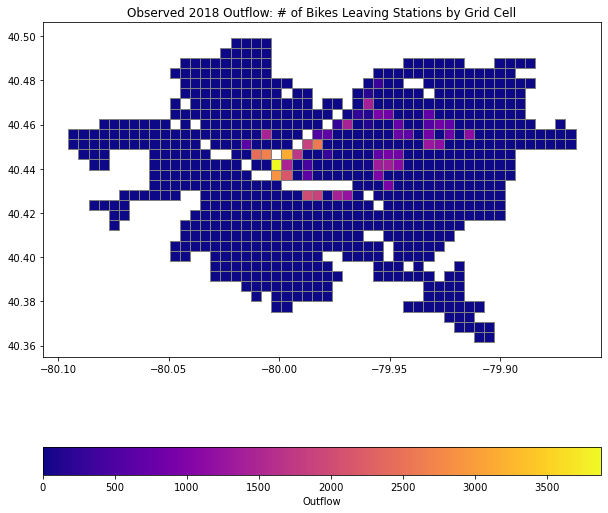

In [380]:
geo_cells.plot(column="2018_outflow", cmap='plasma',edgecolor = "grey", figsize=(10,11),  
                    legend = True, legend_kwds={'label': "Outflow",'orientation': "horizontal"})
plt.title("Observed 2018 Outflow: # of Bikes Leaving Stations by Grid Cell")

Text(0.5, 1.0, 'Observed 2020-12 Outflow: # of Bikes Leaving Stations by Grid Cell')

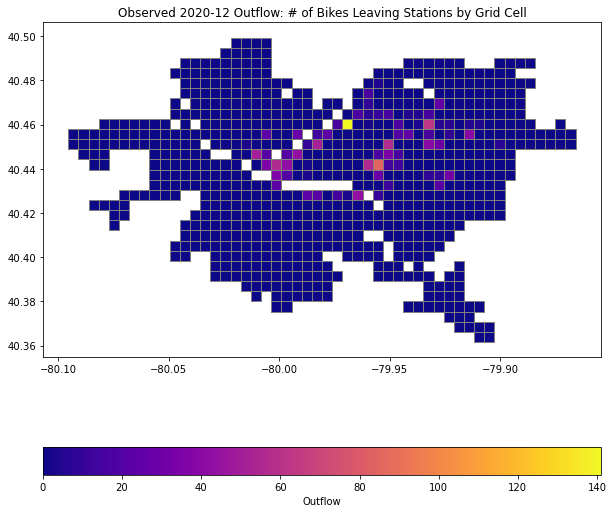

In [29]:
geo_cells.plot(column="2020-12-31", cmap='plasma',edgecolor = "grey", figsize=(10,11),  
                    legend = True, legend_kwds={'label': "Outflow",'orientation': "horizontal"})
plt.title("Observed 2020-12 Outflow: # of Bikes Leaving Stations by Grid Cell")

Text(0.5, 1.0, 'Bike Score from Walk Score API')

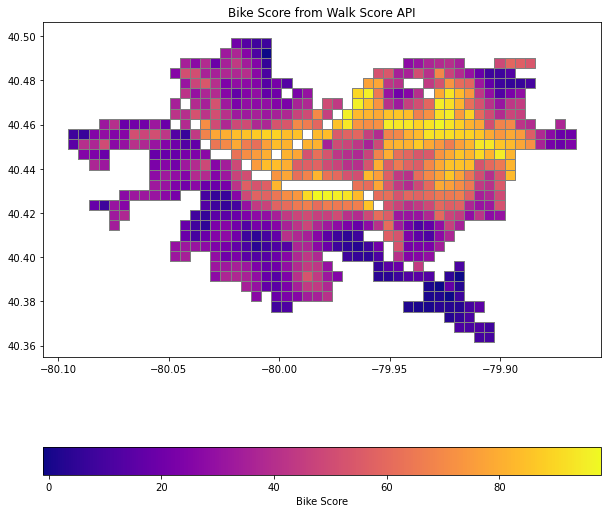

In [382]:
geo_scores_cells.plot(column="bike_score", cmap='plasma',edgecolor = "grey", figsize=(10,11),  
                    legend = True, legend_kwds={'label': "Bike Score",'orientation': "horizontal"})
plt.title("Bike Score from Walk Score API")

Text(0.5, 1.0, 'Walk Score from Walk Score API')

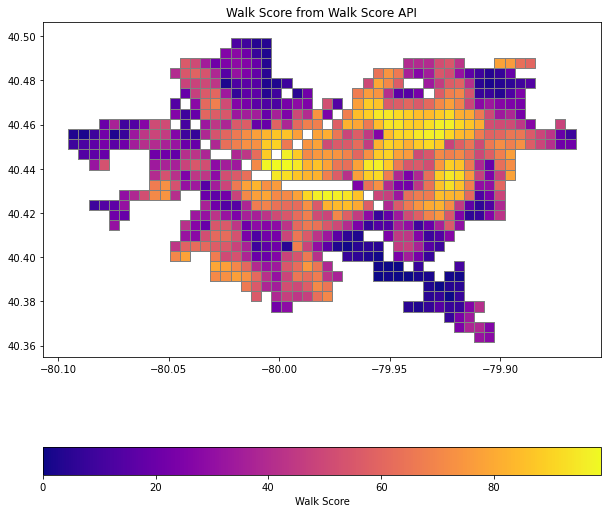

In [394]:
geo_scores_cells.plot(column="walk_score", cmap='plasma',edgecolor = "grey", figsize=(10,11),  
                    legend = True, legend_kwds={'label': "Walk Score",'orientation': "horizontal"})
plt.title("Walk Score from Walk Score API")

Text(0.5, 1.0, 'Transit Score from Walk Score API')

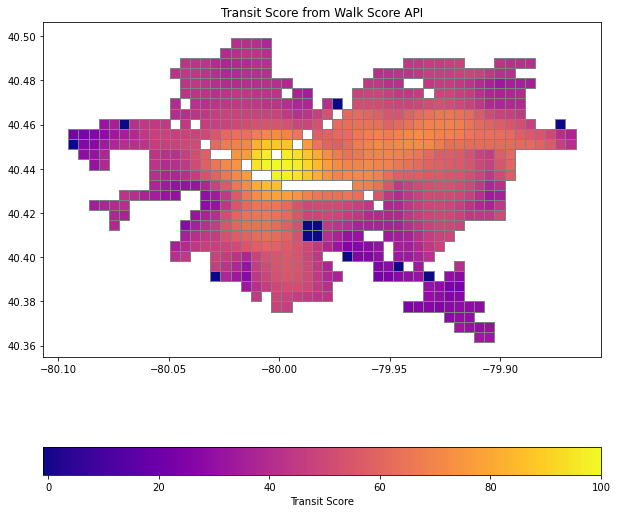

In [393]:
geo_scores_cells.plot(column="transit_score", cmap='plasma',edgecolor = "grey", figsize=(10,11),  
                    legend = True, legend_kwds={'label': "Transit Score",'orientation': "horizontal"})
plt.title("Transit Score from Walk Score API")

Text(0.5, 1.0, 'Total Score from Walk Score API')

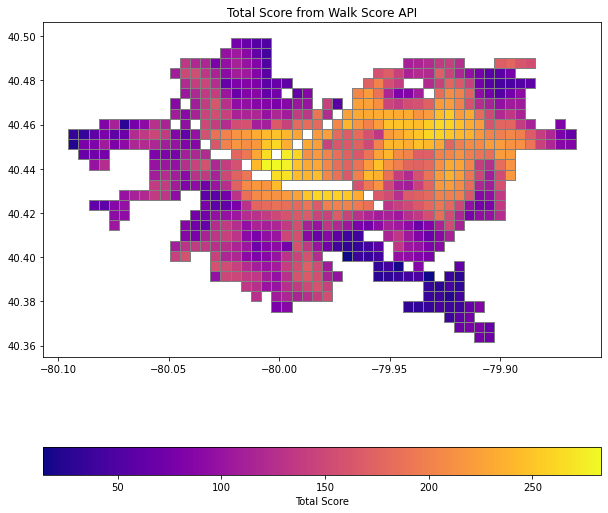

In [395]:
#total score
geo_scores_cells['total_score'] = geo_scores_cells['walk_score'] + geo_scores_cells['bike_score'] + geo_scores_cells['transit_score']
geo_scores_cells.plot(column="total_score", cmap='plasma',edgecolor = "grey", figsize=(10,11),  
                    legend = True, legend_kwds={'label': "Total Score",'orientation': "horizontal"})
plt.title("Total Score from Walk Score API")

Text(0.5, 1.0, 'Observed 2019 Outflow: # of Bikes Leaving Stations by Grid Cell')

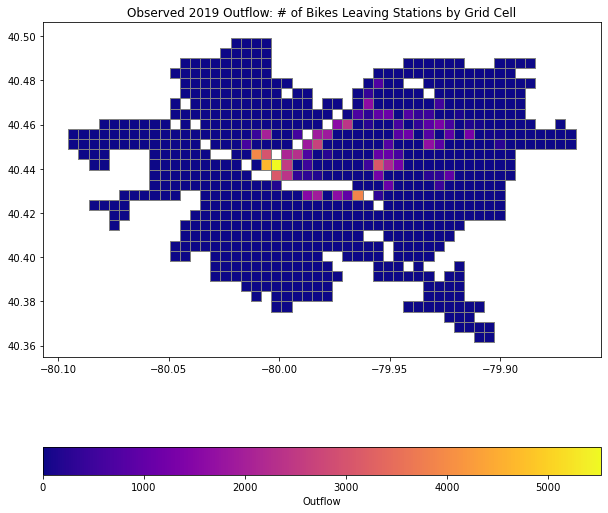

In [383]:
geo_cells.plot(column="2019_outflow", cmap='plasma',edgecolor = "grey", figsize=(10,11),  
                    legend = True, legend_kwds={'label': "Outflow",'orientation': "horizontal"})
plt.title("Observed 2019 Outflow: # of Bikes Leaving Stations by Grid Cell")

Text(0.5, 1.0, 'Observed 2020 Outflow: # of Bikes Leaving Stations by Grid Cell')

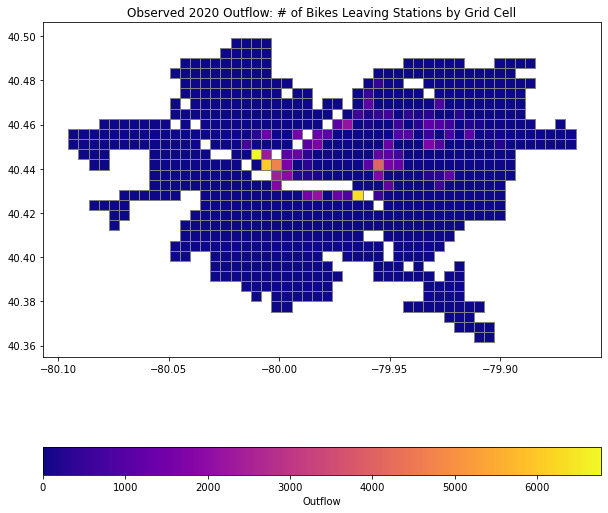

In [384]:
geo_cells.plot(column="2020_outflow", cmap='plasma',edgecolor = "grey", figsize=(10,11),  
                    legend = True, legend_kwds={'label': "Outflow",'orientation': "horizontal"})
plt.title("Observed 2020 Outflow: # of Bikes Leaving Stations by Grid Cell")

Text(0.5, 1.0, 'Predicted 2021 Outflow: # of Bikes Leaving Stations by Grid Cell \n Demand prediction using mean of outflow from last three years')

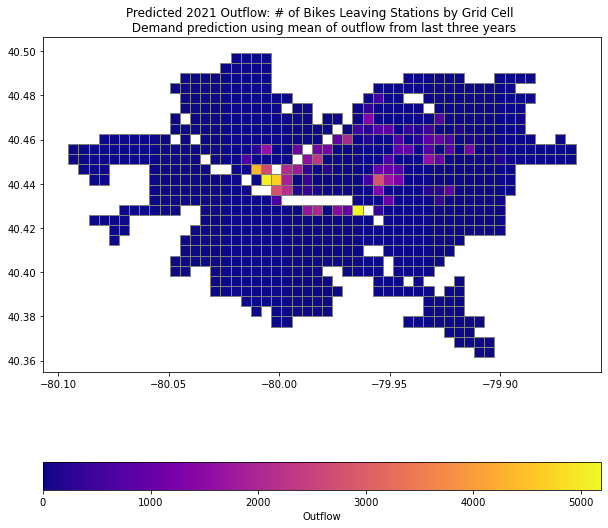

In [385]:
geo_cells.plot(column="pred_outflow", cmap='plasma',edgecolor = "grey", figsize=(10,11),  
                    legend = True, legend_kwds={'label': "Outflow",'orientation': "horizontal"})
plt.title("Predicted 2021 Outflow: # of Bikes Leaving Stations by Grid Cell \n Demand prediction using mean of outflow from last three years")

The predicted outflow which is a proxy for demand of bikes in a grid cell of Pittsburgh is not solely predicting demand for locations that currently have bike stations. The prediction of a grid cell is the mean of the outflow over the last three years. Below we create a proxy for demand for areas that curently don't have bike stations to see how those areas are.

In [295]:
cells_tract_dict = {}

for row,col in geo_cells.iterrows():
    if geo_cells.loc[row]['tractce10'] in cells_tract_dict.keys():
        cells_tract_dict[geo_cells.loc[row]['tractce10']] += 1
    else:
        cells_tract_dict[geo_cells.loc[row]['tractce10']] = 1

for row,col in geo_cells.iterrows():
    if geo_cells.loc[row]['stations'] == 0:
        #create a proxy for demand
        geo_cells.at[row,'pred_outflow'] = (geo_cells.loc[row]['population_16yrs+'] / cells_tract_dict[geo_cells.loc[row]['tractce10']])

In [296]:
geo_cells.head(5)

,cell_num,geometry,centroid,stations,capacity,tractce10,total_households,<$10K,$10K-15K,$15K-25K,...,wfh,mean_travel_time_to_work,perc_public,perc_alone,perc_walk,perc_other,2018_outflow,2019_outflow,2020_outflow,pred_outflow
0,51,"POLYGON ((-80.09534 40.44884, -80.09534 40.453...",POINT (-80.09304131033451 40.45113079550194),0,0,563000,1306,59,33,79,...,58,23,0.156342,0.638938,0.037168,0.0,0,0,0,133
1,52,"POLYGON ((-80.09534 40.45343, -80.09534 40.458...",POINT (-80.09304131033451 40.45572158403908),0,0,563000,1306,59,33,79,...,58,23,0.156342,0.638938,0.037168,0.0,0,0,0,133
2,82,"POLYGON ((-80.09075 40.44424, -80.09075 40.448...",POINT (-80.08845052179737 40.44654000696479),0,0,563000,1306,59,33,79,...,58,23,0.156342,0.638938,0.037168,0.0,0,0,0,133
3,83,"POLYGON ((-80.09075 40.44884, -80.09075 40.453...",POINT (-80.08845052179737 40.45113079550194),0,0,563000,1306,59,33,79,...,58,23,0.156342,0.638938,0.037168,0.0,0,0,0,133
4,84,"POLYGON ((-80.09075 40.45343, -80.09075 40.458...",POINT (-80.08845052179737 40.45572158403908),0,0,563000,1306,59,33,79,...,58,23,0.156342,0.638938,0.037168,0.0,0,0,0,133


Text(0.5, 1.0, 'Predicted 2021 Outflow: # of Bikes Leaving Stations by Grid Cell \n Demand prediction using population older than 16 by census tract')

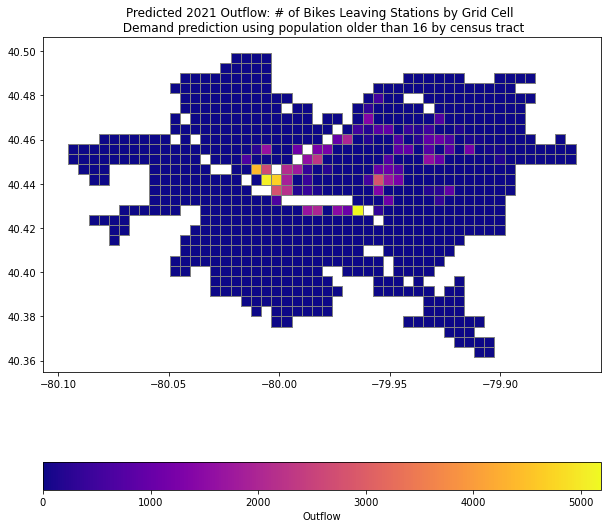

In [386]:
geo_cells.plot(column="pred_outflow", cmap='plasma',edgecolor = "grey", figsize=(10,11),  
                    legend = True, legend_kwds={'label': "Outflow",'orientation': "horizontal"})
plt.title("Predicted 2021 Outflow: # of Bikes Leaving Stations by Grid Cell \n Demand prediction using population older than 16 by census tract")

The above predicted outflow is incorporating the population 16yrs+ in the census tract that the grid cell centroid falls within and is divided by the number of cells that fall within that census tract. This is only calculated for cells that did not previously have bike stations.

In [298]:
cells_tract_dict = {}

for row,col in geo_cells.iterrows():
    if geo_cells.loc[row]['tractce10'] in cells_tract_dict.keys():
        cells_tract_dict[geo_cells.loc[row]['tractce10']] += 1
    else:
        cells_tract_dict[geo_cells.loc[row]['tractce10']] = 1

for row,col in geo_cells.iterrows():
    if geo_cells.loc[row]['stations'] == 0:
        #create a proxy for demand
        geo_cells.at[row,'pred_outflow'] = (geo_cells.loc[row]['population_16yrs+'] / cells_tract_dict[geo_cells.loc[row]['tractce10']]) - (geo_cells.loc[row]['own_alone'] / cells_tract_dict[geo_cells.loc[row]['tractce10']])

Text(0.5, 1.0, 'Predicted 2021 Outflow: # of Bikes Leaving Stations by Grid Cell \n Demand predicted using population older than 16 and population driving to work alone by census tract')

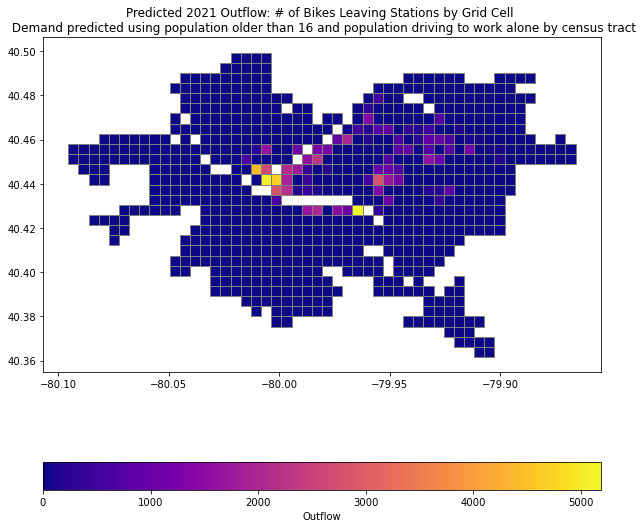

In [387]:
geo_cells.plot(column="pred_outflow", cmap='plasma',edgecolor = "grey", figsize=(10,11),  
                    legend = True, legend_kwds={'label': "Outflow",'orientation': "horizontal"})
plt.title("Predicted 2021 Outflow: # of Bikes Leaving Stations by Grid Cell \n Demand predicted using population older than 16 and population driving to work alone by census tract")

The above predicted outflow is incorporating the population 16yrs+ in the census tract that the grid cell centroid falls within and is divided by the number of cells that fall within that census tract minus the number of people who reported traveling to work alone divided by the number of cells that fall within that census tract. This is only calculated for cells that did not previously have bike stations. The helps adjust for those areas that are purely rural or suburban in or around Pittsburgh.

In [300]:
geo_cells.columns

Index(['cell_num', 'geometry', 'centroid', 'stations', 'capacity', 'tractce10',
       'total_households', '<$10K', '$10K-15K', '$15K-25K', '$25K-35K',
       '$35K-50K', '$50K-75K', '$75K-100K', '$100K-150K', '$150K-200K',
       '>$200K', 'median_hh_income', 'mean_hh_income', '13_x', '14_x', '15_x',
       '16_x', 'population_16yrs+', 'in_labor_force', 'civ_labor_force',
       'employed', 'unemployed', 'armed forces', 'not_in_labor_force',
       'civ_labor_force.1', 'females_16yr+', 'in_labor_force.1',
       'civ_labor_force.2', 'employed.1', '13_y', '14_y', '15_y', '16_y',
       'perc_employed', 'perc_unemployed', 'Workers_16yrs+', 'own_alone',
       'carpool', 'public_transit', 'walked', 'other', 'wfh',
       'mean_travel_time_to_work', 'perc_public', 'perc_alone', 'perc_walk',
       'perc_other', '2018_outflow', '2019_outflow', '2020_outflow',
       'pred_outflow'],
      dtype='object')

In [267]:
ml_df = geo_cells.drop(columns=['cell_num', 'geometry', 'centroid', 'stations', 'capacity', 'tractce10',
                               '<$10K', '$10K-15K', '$15K-25K', '$25K-35K','$35K-50K', '$50K-75K', '$75K-100K', 
                                '$100K-150K', '$150K-200K','>$200K', '13_x', '14_x', '15_x','16_x','armed forces', 
                                'not_in_labor_force','civ_labor_force.1', 'females_16yr+', 'in_labor_force.1',
                                'civ_labor_force.2', 'employed.1', '13_y', '14_y', '15_y', '16_y'])
ml_df.to_csv('../Data/PGH/DemandPrediction/ml_df.csv')

In [405]:
cells_tract_dict = {}

for row,col in geo_scores_cells.iterrows():
    if geo_scores_cells.loc[row]['tractce10'] in cells_tract_dict.keys():
        cells_tract_dict[geo_scores_cells.loc[row]['tractce10']] += 1
    else:
        cells_tract_dict[geo_scores_cells.loc[row]['tractce10']] = 1

for row,col in geo_scores_cells.iterrows():
    if geo_scores_cells.loc[row]['stations'] == 0:
        #create a proxy for demand
        geo_scores_cells.at[row,'pred_outflow'] = (geo_scores_cells.loc[row]['population_16yrs+'] / cells_tract_dict[geo_scores_cells.loc[row]['tractce10']]) - (geo_scores_cells.loc[row]['own_alone'] / cells_tract_dict[geo_scores_cells.loc[row]['tractce10']]) + (geo_scores_cells.loc[row]['bike_score'] * 12) + (geo_scores_cells.loc[row]['walk_score'] * 12)

Text(0.5, 1.0, 'Predicted 2021 Outflow: # of Bikes Leaving Stations by Grid Cell \n Demand predicted using population older than 16 and population driving to work alone by census tract')

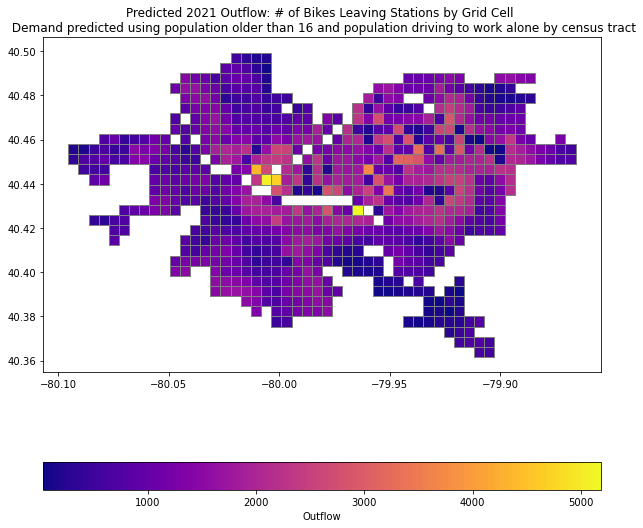

In [406]:
geo_scores_cells.plot(column="pred_outflow", cmap='plasma',edgecolor = "grey", figsize=(10,11),  
                    legend = True, legend_kwds={'label': "Outflow",'orientation': "horizontal"})
plt.title("Predicted 2021 Outflow: # of Bikes Leaving Stations by Grid Cell \n Demand predicted using population older than 16 and population driving to work alone by census tract")